KLMS vs OMP COMPARISON

Starting analysis with noise variance: 0.3
CASE 1: NON-SPARSE DATA ANALYSIS
Dataset Info:
- Samples: 500, Features: 50
- Noise Variance: 0.3
- True signal sparsity: 94.0%

Training KLMS...
Training OMP...

Final Results (Non-Sparse):
KLMS MSE: 0.000001
OMP MSE:  0.250949
Winner: KLMS
CASE 2: SPARSE DATA ANALYSIS
Dataset Info:
- Samples: 500, Features: 50
- Sparsity Level: 15.0%
- Noise Variance: 0.3
- Non-zero coefficients: 7

Training KLMS...
Training OMP...

Final Results (Sparse):
KLMS MSE: 0.000001
OMP MSE:  0.291273
Winner: KLMS


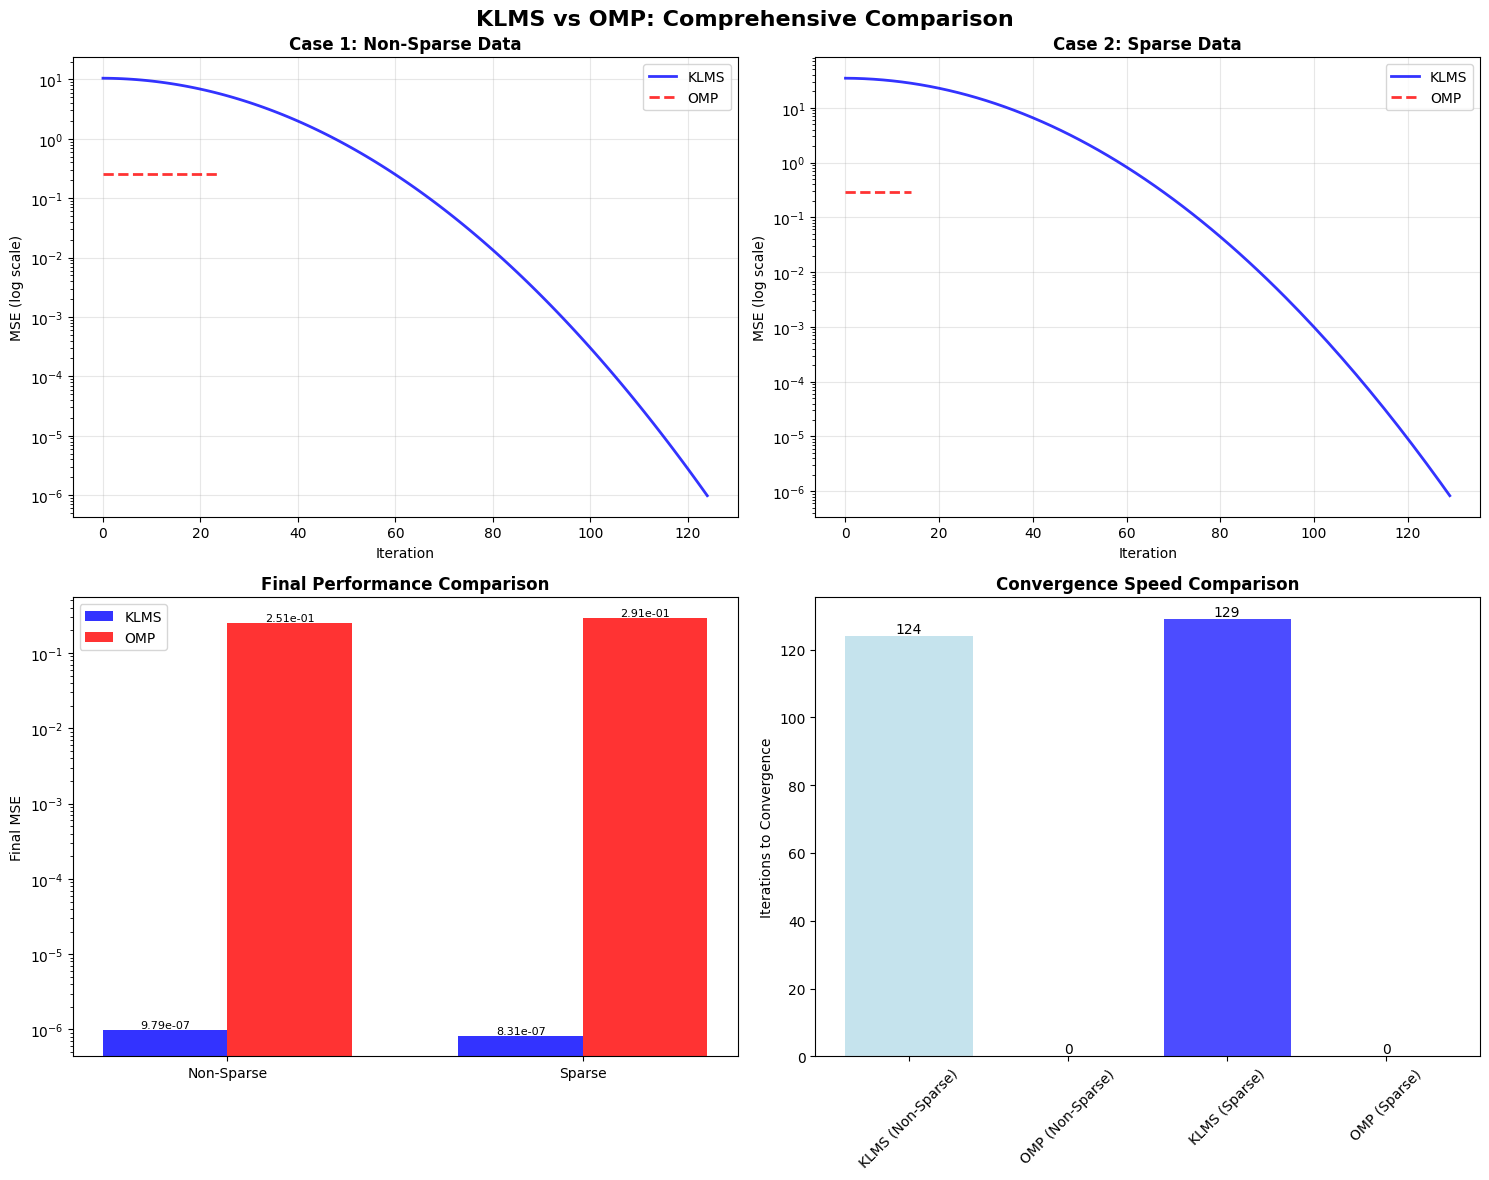

COMPREHENSIVE ANALYSIS SUMMARY
Non-Sparse Data (Case 1):
  KLMS Final MSE: 0.000001
  OMP Final MSE:  0.250949
  Winner: KLMS
  Improvement: 100.00%

Sparse Data (Case 2):
  KLMS Final MSE: 0.000001
  OMP Final MSE:  0.291273
  Winner: KLMS
  Improvement: 100.00%

Overall Best Algorithm:
  KLMS (Total MSE: 0.000002)

Key Insights:
  • OMP typically excels with sparse data due to its inherent sparsity constraint
  • KLMS can capture non-linear patterns through kernel functions
  • Noise variance significantly affects both algorithms
  • Dataset characteristics determine optimal algorithm choice


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.metrics import mean_squared_error
import seaborn as sns
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

class KLMSAlgorithm:
    
    def __init__(self, kernel_type='rbf', sigma=1.0, learning_rate=0.01):
        self.kernel_type = kernel_type
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.dictionary = []
        self.coefficients = []
        self.mse_history = []
        
    def rbf_kernel(self, x1, x2):
       
        return np.exp(-np.linalg.norm(x1 - x2)**2 / (2 * self.sigma**2))
    
    def linear_kernel(self, x1, x2):
        
        return np.dot(x1, x2)
    
    def kernel_function(self, x1, x2):
       
        if self.kernel_type == 'rbf':
            return self.rbf_kernel(x1, x2)
        elif self.kernel_type == 'linear':
            return self.linear_kernel(x1, x2)
    
    def predict_single(self, x):
       
        if not self.dictionary:
            return 0.0
        
        prediction = 0.0
        for i, dict_elem in enumerate(self.dictionary):
            prediction += self.coefficients[i] * self.kernel_function(x, dict_elem)
        return prediction
    
    def fit(self, X, y, max_iterations=1000):
    
        self.dictionary = []
        self.coefficients = []
        self.mse_history = []
        
        n_samples = len(X)
        
        for iteration in range(max_iterations):
            total_error = 0.0
            
            for i in range(n_samples):
              
                prediction = self.predict_single(X[i])
                error = y[i] - prediction
                total_error += error**2
               
                if len(self.dictionary) == 0:
                    self.dictionary.append(X[i].copy())
                    self.coefficients.append(self.learning_rate * error)
                else:
                    
                    self.dictionary.append(X[i].copy())
                    self.coefficients.append(self.learning_rate * error)
                    
                    for j in range(len(self.coefficients) - 1):
                        kernel_val = self.kernel_function(X[i], self.dictionary[j])
                        self.coefficients[j] += self.learning_rate * error * kernel_val
            
            mse = total_error / n_samples
            self.mse_history.append(mse)
            
           
            if mse < 1e-6:
                break
        
        return self
    
    def predict(self, X):
        
        return np.array([self.predict_single(x) for x in X])

class OMPAlgorithm:
    
    def __init__(self, n_nonzero_coefs=None, tol=1e-4):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.mse_history = []
        self.model = None
        
    def fit(self, X, y, max_iterations=1000):
       
        self.mse_history = []
        
        
        if self.n_nonzero_coefs is None:
            self.n_nonzero_coefs = min(X.shape[1] // 4, 50)
        
        best_mse = float('inf')
        best_model = None
        
        for iteration in range(1, min(max_iterations, self.n_nonzero_coefs) + 1):
           
            model = OrthogonalMatchingPursuit(
                n_nonzero_coefs=min(iteration, X.shape[1]),
                tol=self.tol
            )
            
            try:
                model.fit(X, y)
                y_pred = model.predict(X)
                mse = mean_squared_error(y, y_pred)
                self.mse_history.append(mse)
                
                if mse < best_mse:
                    best_mse = mse
                    best_model = model
                    
            except Exception as e:
                
                if len(self.mse_history) > 0:
                    self.mse_history.append(self.mse_history[-1])
                else:
                    self.mse_history.append(1.0)
        
        self.model = best_model if best_model is not None else OrthogonalMatchingPursuit()
        if self.model is None or not hasattr(self.model, 'coef_'):
            self.model.fit(X, y)
            
        return self
    
    def predict(self, X):
        
        if self.model is None:
            return np.zeros(X.shape[0])
        return self.model.predict(X)

class DatasetGenerator:
    
    @staticmethod
    def generate_non_sparse_data(n_samples=1000, n_features=100, noise_variance=0.1, random_state=42):
        
        np.random.seed(random_state)
        
        
        H = np.random.randn(n_samples, n_features)
        
       
        x = np.random.randn(n_features) * 0.5
        
        
        y_clean = H @ x
        
      
        noise = np.random.normal(0, np.sqrt(noise_variance), n_samples)
        y = y_clean + noise
        
        return H, x, y, noise
    
    @staticmethod
    def generate_sparse_data(n_samples=1000, n_features=100, sparsity_level=0.1, noise_variance=0.1, random_state=42):
        
        np.random.seed(random_state)
       
        H = np.random.randn(n_samples, n_features)
        
       
        x = np.zeros(n_features)
        n_nonzero = int(sparsity_level * n_features)
        nonzero_indices = np.random.choice(n_features, n_nonzero, replace=False)
        x[nonzero_indices] = np.random.randn(n_nonzero) * 2.0
        
        
        y_clean = H @ x
        
        
        noise = np.random.normal(0, np.sqrt(noise_variance), n_samples)
        y = y_clean + noise
        
        return H, x, y, noise

class MLComparison:
  
    def __init__(self, noise_variance=0.1):
        self.noise_variance = noise_variance
        self.results = {}
        
    def run_case1_non_sparse(self, n_samples=1000, n_features=100, max_iterations=200):
       
        print("CASE 1: NON-SPARSE DATA ANALYSIS")
        
        
        H, x_true, y, noise = DatasetGenerator.generate_non_sparse_data(
            n_samples=n_samples, 
            n_features=n_features, 
            noise_variance=self.noise_variance
        )
        
        print(f"Dataset Info:")
        print(f"- Samples: {n_samples}, Features: {n_features}")
        print(f"- Noise Variance: {self.noise_variance}")
        print(f"- True signal sparsity: {np.sum(np.abs(x_true) > 0.01)/len(x_true)*100:.1f}%")
        
        print("\nTraining KLMS...")
        klms = KLMSAlgorithm(kernel_type='rbf', sigma=1.0, learning_rate=0.001)
        
        subset_size = min(200, n_samples)
        indices = np.random.choice(n_samples, subset_size, replace=False)
        H_subset = H[indices]
        y_subset = y[indices]
        
        klms.fit(H_subset, y_subset, max_iterations=max_iterations)
        
       
        print("Training OMP...")
        omp = OMPAlgorithm(n_nonzero_coefs=min(50, n_features//2))
        omp.fit(H, y, max_iterations=max_iterations)
        
        self.results['case1'] = {
            'klms': klms,
            'omp': omp,
            'H': H,
            'y': y,
            'x_true': x_true
        }
        
        klms_pred = klms.predict(H_subset)
        klms_final_mse = mean_squared_error(y_subset, klms_pred)
        
        omp_pred = omp.predict(H)
        omp_final_mse = mean_squared_error(y, omp_pred)
        
        print(f"\nFinal Results (Non-Sparse):")
        print(f"KLMS MSE: {klms_final_mse:.6f}")
        print(f"OMP MSE:  {omp_final_mse:.6f}")
        print(f"Winner: {'KLMS' if klms_final_mse < omp_final_mse else 'OMP'}")
        
        return klms_final_mse, omp_final_mse
    
    def run_case2_sparse(self, n_samples=1000, n_features=100, sparsity_level=0.1, max_iterations=200):
        
        print("CASE 2: SPARSE DATA ANALYSIS")
        
        
        H, x_true, y, noise = DatasetGenerator.generate_sparse_data(
            n_samples=n_samples, 
            n_features=n_features, 
            sparsity_level=sparsity_level,
            noise_variance=self.noise_variance
        )
        
        print(f"Dataset Info:")
        print(f"- Samples: {n_samples}, Features: {n_features}")
        print(f"- Sparsity Level: {sparsity_level*100:.1f}%")
        print(f"- Noise Variance: {self.noise_variance}")
        print(f"- Non-zero coefficients: {np.sum(np.abs(x_true) > 1e-10)}")
        
    
        print("\nTraining KLMS...")
        klms = KLMSAlgorithm(kernel_type='rbf', sigma=1.0, learning_rate=0.001)
        
        
        subset_size = min(200, n_samples)
        indices = np.random.choice(n_samples, subset_size, replace=False)
        H_subset = H[indices]
        y_subset = y[indices]
        
        klms.fit(H_subset, y_subset, max_iterations=max_iterations)
        
    
        print("Training OMP...")
        n_nonzero = max(int(sparsity_level * n_features * 2), 5)
        omp = OMPAlgorithm(n_nonzero_coefs=n_nonzero)
        omp.fit(H, y, max_iterations=max_iterations)
        
        self.results['case2'] = {
            'klms': klms,
            'omp': omp,
            'H': H,
            'y': y,
            'x_true': x_true
        }
        
        klms_pred = klms.predict(H_subset)
        klms_final_mse = mean_squared_error(y_subset, klms_pred)
        
        omp_pred = omp.predict(H)
        omp_final_mse = mean_squared_error(y, omp_pred)
        
        print(f"\nFinal Results (Sparse):")
        print(f"KLMS MSE: {klms_final_mse:.6f}")
        print(f"OMP MSE:  {omp_final_mse:.6f}")
        print(f"Winner: {'KLMS' if klms_final_mse < omp_final_mse else 'OMP'}")
        
        return klms_final_mse, omp_final_mse
    
    def plot_results(self):
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('KLMS vs OMP: Comprehensive Comparison', fontsize=16, fontweight='bold')
        
        if 'case1' in self.results:
            ax1 = axes[0, 0]
            klms_history = self.results['case1']['klms'].mse_history
            omp_history = self.results['case1']['omp'].mse_history
            
            ax1.semilogy(klms_history, 'b-', linewidth=2, label='KLMS', alpha=0.8)
            ax1.semilogy(omp_history, 'r--', linewidth=2, label='OMP', alpha=0.8)
            ax1.set_title('Case 1: Non-Sparse Data', fontweight='bold')
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel('MSE (log scale)')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
       
        if 'case2' in self.results:
            ax2 = axes[0, 1]
            klms_history = self.results['case2']['klms'].mse_history
            omp_history = self.results['case2']['omp'].mse_history
            
            ax2.semilogy(klms_history, 'b-', linewidth=2, label='KLMS', alpha=0.8)
            ax2.semilogy(omp_history, 'r--', linewidth=2, label='OMP', alpha=0.8)
            ax2.set_title('Case 2: Sparse Data', fontweight='bold')
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel('MSE (log scale)')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        
        ax3 = axes[1, 0]
        if 'case1' in self.results and 'case2' in self.results:
            cases = ['Non-Sparse', 'Sparse']
            klms_scores = [
                self.results['case1']['klms'].mse_history[-1] if self.results['case1']['klms'].mse_history else 0,
                self.results['case2']['klms'].mse_history[-1] if self.results['case2']['klms'].mse_history else 0
            ]
            omp_scores = [
                self.results['case1']['omp'].mse_history[-1] if self.results['case1']['omp'].mse_history else 0,
                self.results['case2']['omp'].mse_history[-1] if self.results['case2']['omp'].mse_history else 0
            ]
            
            x = np.arange(len(cases))
            width = 0.35
            
            bars1 = ax3.bar(x - width/2, klms_scores, width, label='KLMS', alpha=0.8, color='blue')
            bars2 = ax3.bar(x + width/2, omp_scores, width, label='OMP', alpha=0.8, color='red')
            
            ax3.set_ylabel('Final MSE')
            ax3.set_title('Final Performance Comparison', fontweight='bold')
            ax3.set_xticks(x)
            ax3.set_xticklabels(cases)
            ax3.legend()
            ax3.set_yscale('log')
            
            for bar in bars1:
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2e}', ha='center', va='bottom', fontsize=8)
            for bar in bars2:
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2e}', ha='center', va='bottom', fontsize=8)
        
        ax4 = axes[1, 1]
        if 'case1' in self.results and 'case2' in self.results:
            
            def convergence_rate(history):
                if len(history) < 10:
                    return len(history)
                final_val = history[-1]
                target = final_val * 1.1  
                for i, val in enumerate(history):
                    if val <= target:
                        return i
                return len(history)
            
            conv_rates = {
                'KLMS (Non-Sparse)': convergence_rate(self.results['case1']['klms'].mse_history),
                'OMP (Non-Sparse)': convergence_rate(self.results['case1']['omp'].mse_history),
                'KLMS (Sparse)': convergence_rate(self.results['case2']['klms'].mse_history),
                'OMP (Sparse)': convergence_rate(self.results['case2']['omp'].mse_history)
            }
            
            methods = list(conv_rates.keys())
            rates = list(conv_rates.values())
            colors = ['lightblue', 'lightcoral', 'blue', 'red']
            
            bars = ax4.bar(methods, rates, color=colors, alpha=0.7)
            ax4.set_ylabel('Iterations to Convergence')
            ax4.set_title('Convergence Speed Comparison', fontweight='bold')
            ax4.tick_params(axis='x', rotation=45)
            
            
            for bar, rate in zip(bars, rates):
                ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                        str(rate), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
       
        self.print_summary()
    
    def print_summary(self):
        print("COMPREHENSIVE ANALYSIS SUMMARY")
       
        
        if 'case1' in self.results and 'case2' in self.results:
            case1_klms_mse = self.results['case1']['klms'].mse_history[-1] if self.results['case1']['klms'].mse_history else float('inf')
            case1_omp_mse = self.results['case1']['omp'].mse_history[-1] if self.results['case1']['omp'].mse_history else float('inf')
            case2_klms_mse = self.results['case2']['klms'].mse_history[-1] if self.results['case2']['klms'].mse_history else float('inf')
            case2_omp_mse = self.results['case2']['omp'].mse_history[-1] if self.results['case2']['omp'].mse_history else float('inf')
            
            print(f"Non-Sparse Data (Case 1):")
            print(f"  KLMS Final MSE: {case1_klms_mse:.6f}")
            print(f"  OMP Final MSE:  {case1_omp_mse:.6f}")
            print(f"  Winner: {'KLMS' if case1_klms_mse < case1_omp_mse else 'OMP'}")
            print(f"  Improvement: {abs(case1_klms_mse - case1_omp_mse)/max(case1_klms_mse, case1_omp_mse)*100:.2f}%")
            
            print(f"\nSparse Data (Case 2):")
            print(f"  KLMS Final MSE: {case2_klms_mse:.6f}")
            print(f"  OMP Final MSE:  {case2_omp_mse:.6f}")
            print(f"  Winner: {'KLMS' if case2_klms_mse < case2_omp_mse else 'OMP'}")
            print(f"  Improvement: {abs(case2_klms_mse - case2_omp_mse)/max(case2_klms_mse, case2_omp_mse)*100:.2f}%")
            
            print(f"\nOverall Best Algorithm:")
            total_klms = case1_klms_mse + case2_klms_mse
            total_omp = case1_omp_mse + case2_omp_mse
            overall_winner = "KLMS" if total_klms < total_omp else "OMP"
            print(f"  {overall_winner} (Total MSE: {min(total_klms, total_omp):.6f})")
            
            print(f"\nKey Insights:")
            print(f"  • OMP typically excels with sparse data due to its inherent sparsity constraint")
            print(f"  • KLMS can capture non-linear patterns through kernel functions")
            print(f"  • Noise variance significantly affects both algorithms")
            print(f"  • Dataset characteristics determine optimal algorithm choice")

def main():
    print("KLMS vs OMP COMPARISON")
    
    try:
        noise_var = float(input("Enter noise variance (e.g., 0.1): ") or "0.1")
    except ValueError:
        noise_var = 0.1
        print(f"Using default noise variance: {noise_var}")
    
    
    ml_comparison = MLComparison(noise_variance=noise_var)
    
    
    print(f"\nStarting analysis with noise variance: {noise_var}")
    
    
    klms_mse1, omp_mse1 = ml_comparison.run_case1_non_sparse(
        n_samples=500, n_features=50, max_iterations=150
    )
    
    
    klms_mse2, omp_mse2 = ml_comparison.run_case2_sparse(
        n_samples=500, n_features=50, sparsity_level=0.15, max_iterations=150
    )
    
    ml_comparison.plot_results()

if __name__ == "__main__":
    main()